# Introduction to Neural Networks 


** Ecole Centrale Nantes **

** Diana Mateus **


** Participants : **



## General description
In this lab we will create a simple classifier based on neural networks. We will progress in two parts:
- In the first part, and to better understand the involved operations, we will create a single-neuron model and optimize its parameters "by hand". For this first part we will only use the **Numpy** library
- We will then build a multi-layer perceptron with the built-in library **Keras** module and **tensorflow**. Tensorflow is already installed in the university computers. If using your own computer you should have already installed **tensorflow** or use **collab** online platform.




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

### Loading the dataset
Start by runing the following lines to load and visualize the data.

In [2]:
def load_dataset():
    train_dataset = h5py.File('dataset/train_catvnoncat.h5', "r")
    train_x = np.array(train_dataset["train_set_x"][:]) 
    train_y = np.array(train_dataset["train_set_y"][:])
    test_dataset = h5py.File('dataset/test_catvnoncat.h5', "r")
    test_x = np.array(test_dataset["test_set_x"][:]) 
    test_y = np.array(test_dataset["test_set_y"][:])
    classes = np.array(test_dataset["list_classes"][:]) 
    
    train_y = train_y.reshape((1, train_y.shape[0]))
    test_y = test_y.reshape((1, test_y.shape[0]))
    
    return train_x, train_y, test_x, test_y, classes

train_x, train_y, test_x, test_y, classes=load_dataset()

#### Visualize data

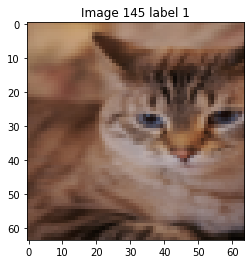

Train X shape: (209, 64, 64, 3)
We have 209 images of dimensionality 64x64x3


In [3]:
# run several times to visualize different data points
# the title shows the ground truth class labels (0=no cat , 1 = cat)
index = np.random.randint(low=0,high=train_y.shape[1])
plt.imshow(train_x[index])
plt.title("Image "+str(index)+" label "+str(train_y[0,index]))
plt.show()
print ("Train X shape: " + str(train_x.shape))
print ("We have "+str(train_x.shape[0]), 
       "images of dimensionality " 
       + str(train_x.shape[1])+ "x"
       + str(train_x.shape[2])+ "x"
       + str(train_x.shape[3]))

#### Preprocessing
In the following lines we vectorize the images (Instead of a 2-D image we will give as input to the models a 1-D vector). The normalization makes the image intensities be between 0 and 1, and converts the images to floats.

In [4]:
train_x = train_x.reshape(train_x.shape[0], -1).T
test_x = test_x.reshape(test_x.shape[0], -1).T
print ("Train X shape: " + str(train_x.shape))
print ("Train Y shape: " + str(train_y.shape))
print ("Test X shape: " + str(test_x.shape))
print ("Test Y shape: " + str(test_y.shape))

Train X shape: (12288, 209)
Train Y shape: (1, 209)
Test X shape: (12288, 50)
Test Y shape: (1, 50)


In [5]:
train_x = train_x/255.
test_x = test_x/255.

### 1. Classification with a single neuron 


**a)** Fill-in the following three functions to define the single neuron model (a single neuron in the hidden layer):
- A function **initialize_parameters** of the neuron. The function will randomly initializes the model's weights with small values. Initialize the bias with 0. What is the number of weights required? pass this information as a parameter to the function.
- A function **sigmoid** that computes the sigmoid activation function
- A function **neuron** that given an input vector, the weights and bias, computes the output of the single neuron model

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [7]:
def initialize_parameters(dim):
    w = np.random.randn(dim, 1) * 0.001
    b = 0.0
    return w, b

In [8]:
def neuron(w,b,X):
    pred_y = sigmoid(np.matmul(w.T, X) + b)
    return pred_y

**b)** **Forward Pass:**
Use the three functions above to compute a first forward pass for the input matrix $X$ containing the loaded dataset, for some initialization of the weights and bias.
 
 \begin{align}
 Y_{\rm pred}=\sigma(w^\top X+b) = [y_{\rm pred}^{(1)},y_{\rm pred}^{(2)},\dots,y_{\rm pred}^{(m)}]
 \end{align}
 

In [9]:
dim = train_x.shape[0]
w, b = initialize_parameters(dim)
print(w.shape)
pred_y = neuron(w, b, train_x)

(12288, 1)


**c) Cost estimation:**
 
We will use a binary cross-entropy loss, so that the empirical risk can be computed as:
 \begin{align}
 E = - \frac{1}{m} \sum_{i=1}^m 
 y^{(i)} \log(y_{\rm pred}^{(i)}) +
 (1-y^{(i)}) \log(1-y_{\rm pred}^{(i)})
 \end{align}
 
 The following cross-entropy function should give as result the scalar cost value computed over the entire dataset

In [57]:
def crossentropy(Y,Ypred):
    eps = 10**(-12)
    cost = -np.sum(Y * np.log(Ypred + eps) + (1 - Y) * np.log(1 - Ypred + eps)) / Ypred.shape[1]
    
    return cost

**d) Back propagation:**

After initializing the parameters and doing a forward pass, we need to backpropagate the cost by computing the gradient with respect to the model parameters to later update the weights

\begin{align}
\frac{\partial E}{\partial w} = \\
\frac{\partial E}{\partial b} = 
\end{align}

See a demonstration of the gradient computation in 
https://en.wikipedia.org/wiki/Cross_entropy

Fill-in the backpropagation function which receives as input the the training set (X,Y), as well as the current predictions and returns the gradients updates for the weights and bias

Hint: When the error is computed for several samples simultaneously, the gradient is averaged over the contribution of different samples.

In [11]:
def backpropagate(X, Y, Ypred):
    m = X.shape[1]
    
    #find gradient (back propagation)
    dw = np.matmul(X, (Ypred - Y).T) / m
    db = np.sum(Ypred - Y) / m
    grads = {"dw": dw,
             "db": db} 
    
    return grads

grads = backpropagate(train_x, train_y.ravel(), pred_y)

**e) Optimization**
After initializing the parameters, computing the cost function, and calculating gradients, we can now update the parameters using gradient descent. Use the functions implemented above to fill_in the "gradient_descent" function that optimizes the parameters given a training set X, Y, a fixed number of iterations, and a learning_rate. Store and plot the value of the loss function at each iteration

In [83]:
def gradient_descent(X, Y, iterations, learning_rate):
    costs = []
    w, b = initialize_parameters(X.shape[0])
    
    for i in range(iterations):
        Ypred = neuron(w, b, X)
        cost = crossentropy(Y, Ypred)
        grads = backpropagate(X, Y, Ypred)
        
        #update parameters
        w -= learning_rate * grads['dw']
        b -= learning_rate * grads['db']
        costs.append(cost)
        
        if i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
       
    return w,b, costs

w, b, costs = gradient_descent(train_x,train_y.ravel(),iterations=2000, learning_rate = 0.005)

Cost after iteration 0: 0.707561
Cost after iteration 100: 0.583927
Cost after iteration 200: 0.466447
Cost after iteration 300: 0.375661
Cost after iteration 400: 0.331273
Cost after iteration 500: 0.303111
Cost after iteration 600: 0.279737
Cost after iteration 700: 0.259914
Cost after iteration 800: 0.242823
Cost after iteration 900: 0.227895
Cost after iteration 1000: 0.214718
Cost after iteration 1100: 0.202983
Cost after iteration 1200: 0.192455
Cost after iteration 1300: 0.182949
Cost after iteration 1400: 0.174319
Cost after iteration 1500: 0.166446
Cost after iteration 1600: 0.159234
Cost after iteration 1700: 0.152600
Cost after iteration 1800: 0.146479
Cost after iteration 1900: 0.140812


**e) Plot the training curve**
Plot the evolution of the cost vs the iterations 

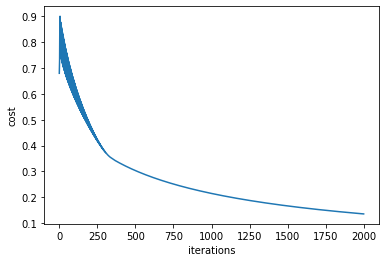

In [13]:
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations')
plt.show()

**f) Prediction**
Use the optimized parameters to make predictions both for the train and test sets and compute the accuracy for each. What do you observe?

In [84]:
def predict(w, b, X):    
    y_pred = neuron(w, b, X)
    return y_pred

# predict 
train_pred_y = predict(w, b, train_x)
test_pred_y = predict(w, b, test_x)
print("Train Acc: {} %".format(100 - np.mean(np.abs(train_pred_y - train_y)) * 100))
print("Test Acc: {} %".format(100 - np.mean(np.abs(test_pred_y - test_y)) * 100))

Train Acc: 88.07597638503455 %
Test Acc: 64.88331547226271 %


**g) Early stopping** 
- Adapt the gradient descent function to consider part (a percentage) of the training data for validation. Use the validation set to choose the training hyperparameters (learning_rate, iterations). 
- Plot the training and validation curves
- Report again the training and test accuracy and loss for the new trained model
- What do you observe



In [86]:
def gradient_descent_early_stopping(X, Y, iterations, learning_rate, percentage=.1):
    max_ind = int(Y.shape[0] * (1 - percentage))
    train_x, val_x = X[:, :max_ind], X[:, max_ind:]
    train_y, val_y = Y[:max_ind], Y[max_ind:]
    
    train_costs, val_costs = [], []
    w, b = initialize_parameters(train_x.shape[0])
    
    for i in range(iterations):
        Ypred = neuron(w, b, val_x)
        val_cost = crossentropy(val_y, Ypred)
        
        Ypred = neuron(w, b, train_x)
        train_cost = crossentropy(train_y, Ypred)
        grads = backpropagate(train_x, train_y, Ypred)
        
        #update parameters
        w -= learning_rate * grads['dw']
        b -= learning_rate * grads['db']
       
        train_costs.append(train_cost)
        val_costs.append(val_cost)
        
        # if i % 100 == 0:
        #     print ("Train cost after iteration %i: %f" %(i, train_cost))
        #     print ("Val cost after iteration %i: %f" %(i, val_cost))
    
    return w, b, train_costs, val_costs

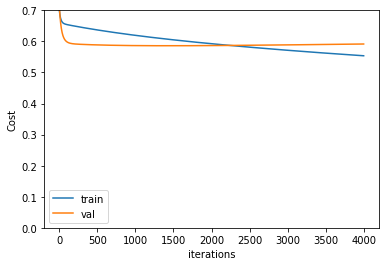

In [139]:
w, b, train_costs, val_costs = gradient_descent_early_stopping(train_x, train_y.ravel(), 4000, learning_rate=0.00005)

plt.plot(train_costs)
plt.plot(val_costs)
plt.legend(['train', 'val'])
plt.ylabel('Cost')
plt.xlabel('iterations')
plt.ylim([0, 0.7])

plt.show()

On observe qu'à partir d'environ 2000 itérations la courbe d'entrainement passe en dessous de celle de validation ce qui signifie qu'il y a overfitting. Pour la valeur de `learning_rate` utilisée en e) on observe que la courbe de validation commence à croitre rapidement, ce qui n'est pas souhaitable.

In [136]:
train_pred_y = predict(w, b, train_x)
test_pred_y = predict(w, b, test_x)
loss =  crossentropy(train_y, train_pred_y)
print("Train Acc: {} %".format(100 - np.mean(np.abs(train_pred_y - train_y)) * 100))
print("Test Acc: {} %".format(100 - np.mean(np.abs(test_pred_y - test_y)) * 100))
print("Loss: {}".format(loss))

Train Acc: 55.169847051912775 %
Test Acc: 46.65695977876525 %
Loss: 0.6229553595264804


En diminuant alors la valeur du `learning_rate` on évite que la courbe de validation décole mais le learning rate devient alors insufisant pour diminuer la fonction de coût jusqu'à la même valeur qu'en d) et on obtient donc de moins bonnes performances dans ce cas.

### 2. CNNs with Keras

Adapt the example in this website https://keras.io/examples/vision/mnist_convnet/ to our problem. To this end:
- change the number of classes and the input size
- remove the expand_dims(x_train, -1): it is not necessary to expand the dimensions since our input is 3-dimensional 
- you may need to transpose the labels vector
- change the categorical cross-entropy to the binary cross entropy given that our problem is binary classification. 
- also change the softmax to sigmoid, the more appropriate activation function for binary data

We can choose a single neuron output passed through sigmoid, and then set a threshold to choose the class, or use two neuron output and then perform a softmax.

**2.1** Can you get the accuracy better than in our hand single-neuron model?Try different configurations and explain the changes you have made.

**2.2** Compute the train and test loss and accuracy after the model has been trained.  What model parameters does the ``fit`` function retain?

**2.3** How many parameters does the network have, explain where the number comes from.

**2.4** What is the receptive field of the network https://distill.pub/2019/computing-receptive-fields/

In [140]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [141]:
# the data, split between train and test sets
x_train, y_train, x_test, y_test, classes=load_dataset()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# convert class vectors to binary class matrices
y_train = y_train.T
y_test = y_test.T

num_classes = 1
input_shape = (64, 64, 3)

In [142]:
#build the model
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="sigmoid"),
    ])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                                 
 dropout_1 (Dropout)         (None, 12544)            

In [143]:
#comiple and fit
batch_size = 128
epochs = 15

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
2/2 [==============================] - 1s 200ms/step - loss: 0.6569 - accuracy: 0.6383 - val_loss: 0.5186 - val_accuracy: 0.8095
Epoch 2/15
2/2 [==============================] - 0s 107ms/step - loss: 0.6498 - accuracy: 0.6383 - val_loss: 0.5428 - val_accuracy: 0.8095
Epoch 3/15
2/2 [==============================] - 0s 122ms/step - loss: 0.6019 - accuracy: 0.6383 - val_loss: 0.5474 - val_accuracy: 0.8095
Epoch 4/15
2/2 [==============================] - 0s 108ms/step - loss: 0.5728 - accuracy: 0.6383 - val_loss: 0.5103 - val_accuracy: 0.8095
Epoch 5/15
2/2 [==============================] - 0s 131ms/step - loss: 0.5365 - accuracy: 0.6383 - val_loss: 0.4998 - val_accuracy: 0.8095
Epoch 6/15
2/2 [==============================] - 0s 107ms/step - loss: 0.5116 - accuracy: 0.6330 - val_loss: 0.5055 - val_accuracy: 0.7143
Epoch 7/15
2/2 [==============================] - 0s 110ms/step - loss: 0.4840 - accuracy: 0.6755 - val_loss: 0.5180 - val_accuracy: 0.7143
Epoch 8/15
2/2 [====

In [146]:
#evaluate

score = model.evaluate(x_train, y_train, verbose=0)
print("Train loss:", score[0])
print("Train accuracy:", score[1])
print('')

score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Train loss: 0.3517521321773529
Train accuracy: 0.8564593195915222

Test loss: 0.5779209136962891
Test accuracy: 0.699999988079071


**2.2)** La fonction fit prend en argument :

* `x_train`
* `y_train`
* `batch_size` : le nombre d'échantillons à considérer pour les calculs du gradient
* `epochs` : le nombre de fois où le modèle voit chaque feature
* `validation_split` : le pourcentage de données utilisées pour la validation 

**2.3)** Le modèle dispose de **31937** paramètres : 

* La première couche de convolution dispose de : $3 \times 3 \times 32 \times 3 + 32 = 896$ paramètres
* La deuxième couche de convolution dispose de : $3 \times 3 \times 64 \times 32 + 64 = 18496$ paramètres
* la couche dense comporte $12545$ paramètres